https://www.transtats.bts.gov/Fields.asp?Table_ID=236

In [1]:
from __future__ import division #, print_function # Imports from __future__ since we're running Python 2

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [219]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
random_state = 10 # Ensure reproducible results
%matplotlib inline
plt.style.use('ggplot')
from flights_delay.feature_processing import FlightDelayFeatureProcessing
from helpers.outliers import MyOutliers
from helpers.feature_engineering import makeBinaryClassification, getUniqueValuesPerFeature
from sklearn.model_selection import train_test_split
from helpers.plot_helper import plotDistsPerClass, plotBothDists
from flights_delay.feature_prev_delays import FeaturePrevDelays
from flights_delay.feature_airline_delays import FeatureAirlineDelays
from helpers.my_one_hot_encoder import MyOneHotEncoder

In [4]:
data_relative_path = '../Data'

# Flying to New York City - Feature Engineering

In [5]:
path_data = os.path.realpath(os.path.join(os.getcwd(), data_relative_path, 'train_data_v2.csv'))
assert os.path.isfile(path_data)
path_data

'/home/student/pligor.george@gmail.com/msc_Artificial_Intelligence/dme_Data_Mining/dmedatarats/Data/train_data_v2.csv'

In [6]:
df = pd.read_csv(path_data, delimiter = ',', header=0)
df.shape

(31186, 21)

In [7]:
print("There are {} entries and {} columns in the DataFrame"\
      .format(df.shape[0], df.shape[1]))

There are 31186 entries and 21 columns in the DataFrame


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31186 entries, 0 to 31185
Data columns (total 21 columns):
QUARTER             31186 non-null int64
MONTH               31186 non-null int64
DAY_OF_MONTH        31186 non-null int64
DAY_OF_WEEK         31186 non-null int64
UNIQUE_CARRIER      31186 non-null object
ORIGIN              31186 non-null object
ORIGIN_CITY_NAME    31186 non-null object
ORIGIN_STATE_ABR    31186 non-null object
DEST                31186 non-null object
DEST_CITY_NAME      31186 non-null object
DEST_STATE_ABR      31186 non-null object
DEP_TIME            31186 non-null float64
DEP_DELAY           31186 non-null float64
DEP_DELAY_NEW       31186 non-null float64
DEP_DEL15           31186 non-null float64
DEP_DELAY_GROUP     31186 non-null float64
DEP_TIME_BLK        31186 non-null object
CRS_ELAPSED_TIME    31186 non-null float64
DISTANCE            31186 non-null float64
DISTANCE_GROUP      31186 non-null int64
IS_DELAYED          31186 non-null bool
dtypes: b

In [9]:
df.sample(10)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,...,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,IS_DELAYED
11075,3,9,4,7,DL,ATL,"Atlanta, GA",GA,LGA,"New York, NY",...,1542.0,-3.0,0.0,0.0,-1.0,1500-1559,140.0,762.0,4,False
14671,1,2,20,6,AA,MIA,"Miami, FL",FL,LGA,"New York, NY",...,1356.0,-13.0,0.0,0.0,-1.0,1400-1459,171.0,1096.0,5,False
25778,4,10,17,1,VX,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",...,1747.0,52.0,52.0,1.0,3.0,1600-1659,375.0,2475.0,10,True
11498,3,8,15,1,UA,LGA,"New York, NY",NY,ORD,"Chicago, IL",...,1622.0,77.0,77.0,1.0,5.0,1500-1559,161.0,733.0,3,True
29725,3,9,28,3,AA,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",...,2111.0,-4.0,0.0,0.0,-1.0,2100-2159,336.0,2475.0,10,False
8055,2,6,11,6,AA,LGA,"New York, NY",NY,ORD,"Chicago, IL",...,2051.0,112.0,112.0,1.0,7.0,1800-1859,171.0,733.0,3,True
20514,4,10,2,7,NK,LGA,"New York, NY",NY,ORD,"Chicago, IL",...,2140.0,-19.0,0.0,0.0,-2.0,2100-2159,141.0,733.0,3,False
26953,2,6,25,6,AA,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",...,2110.0,10.0,10.0,0.0,0.0,2100-2159,369.0,2475.0,10,False
3501,2,6,24,5,AA,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",...,2232.0,2.0,2.0,0.0,0.0,2200-2259,377.0,2475.0,10,True
17460,3,9,13,2,B6,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",...,1134.0,-1.0,0.0,0.0,-1.0,1100-1159,328.0,2475.0,10,False


In [10]:
XX = df.drop(labels=['IS_DELAYED'], axis=1)
yy = df['IS_DELAYED']
XX.shape, yy.shape

((31186, 20), (31186,))

#### Binarize Quarter
Because we saw from distributions that Quarter 3 has more delayed flights, so Quarter 3 becomes True and rest of Quarters become False

In [11]:
df_1 = FlightDelayFeatureProcessing.binarizeQuarter(XX)
df_1.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
16192,1,7,9,6,B6,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,619.0,-1.0,0.0,0.0,-1.0,0600-0659,328.0,2475.0,10
10496,0,10,4,2,VX,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,734.0,-1.0,0.0,0.0,-1.0,0700-0759,315.0,2475.0,10
18939,1,7,14,4,B6,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",CA,544.0,-1.0,0.0,0.0,-1.0,0001-0559,346.0,2475.0,10
30189,0,12,26,1,NK,LGA,"New York, NY",NY,ORD,"Chicago, IL",IL,2154.0,-5.0,0.0,0.0,-1.0,2100-2159,147.0,733.0,3
25267,0,6,14,2,DL,JFK,"New York, NY",NY,SFO,"San Francisco, CA",CA,1701.0,11.0,11.0,0.0,0.0,1600-1659,408.0,2586.0,11


#### Binarize Month
From the distribution plot it seems that the summer months have more delayed flights in comparison to delayed flights than any other period. So for June, July and August we have 1 and for the rest of months we have zero

In [12]:
df_1.loc[25267, 'MONTH']

6

In [13]:
df_2 = FlightDelayFeatureProcessing.binarizeMonth(df_1)
df_2.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
16192,1,1,9,6,B6,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,619.0,-1.0,0.0,0.0,-1.0,0600-0659,328.0,2475.0,10
10496,0,0,4,2,VX,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,734.0,-1.0,0.0,0.0,-1.0,0700-0759,315.0,2475.0,10
18939,1,1,14,4,B6,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",CA,544.0,-1.0,0.0,0.0,-1.0,0001-0559,346.0,2475.0,10
30189,0,0,26,1,NK,LGA,"New York, NY",NY,ORD,"Chicago, IL",IL,2154.0,-5.0,0.0,0.0,-1.0,2100-2159,147.0,733.0,3
25267,0,1,14,2,DL,JFK,"New York, NY",NY,SFO,"San Francisco, CA",CA,1701.0,11.0,11.0,0.0,0.0,1600-1659,408.0,2586.0,11


#### Binarize day of month
Again we do not consider the day of month to be of particular importance but we see that between the 14th to the 18th of month there are more delayed flights than not

In [14]:
df_3 = FlightDelayFeatureProcessing.binarizeDayOfMonth(df_2)
df_3.shape

(31186, 20)

In [15]:
df_2.loc[18939, 'DAY_OF_MONTH']

14

In [16]:
df_3.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
16192,1,1,0,6,B6,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,619.0,-1.0,0.0,0.0,-1.0,0600-0659,328.0,2475.0,10
10496,0,0,0,2,VX,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,734.0,-1.0,0.0,0.0,-1.0,0700-0759,315.0,2475.0,10
18939,1,1,1,4,B6,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",CA,544.0,-1.0,0.0,0.0,-1.0,0001-0559,346.0,2475.0,10
30189,0,0,0,1,NK,LGA,"New York, NY",NY,ORD,"Chicago, IL",IL,2154.0,-5.0,0.0,0.0,-1.0,2100-2159,147.0,733.0,3
25267,0,1,1,2,DL,JFK,"New York, NY",NY,SFO,"San Francisco, CA",CA,1701.0,11.0,11.0,0.0,0.0,1600-1659,408.0,2586.0,11


#### Binarize Day of week
For some reason Thursday and Friday is more likely to get a delayed flight than any other day

In [17]:
df_4 = FlightDelayFeatureProcessing.binarizeDayOfWeek(df_3)
df_4.shape

(31186, 20)

In [18]:
df_3.loc[18939, 'DAY_OF_WEEK']

4

In [19]:
df_4.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP
16192,1,1,0,0,B6,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,619.0,-1.0,0.0,0.0,-1.0,0600-0659,328.0,2475.0,10
10496,0,0,0,0,VX,LAX,"Los Angeles, CA",CA,JFK,"New York, NY",NY,734.0,-1.0,0.0,0.0,-1.0,0700-0759,315.0,2475.0,10
18939,1,1,1,1,B6,JFK,"New York, NY",NY,LAX,"Los Angeles, CA",CA,544.0,-1.0,0.0,0.0,-1.0,0001-0559,346.0,2475.0,10
30189,0,0,0,0,NK,LGA,"New York, NY",NY,ORD,"Chicago, IL",IL,2154.0,-5.0,0.0,0.0,-1.0,2100-2159,147.0,733.0,3
25267,0,1,1,0,DL,JFK,"New York, NY",NY,SFO,"San Francisco, CA",CA,1701.0,11.0,11.0,0.0,0.0,1600-1659,408.0,2586.0,11


### Origin

In [20]:
np.unique(df_4['ORIGIN'])

array(['ATL', 'JFK', 'LAX', 'LGA', 'MIA', 'ORD', 'SFO'], dtype=object)

In [21]:
np.unique(df_4['ORIGIN_CITY_NAME'])

array(['Atlanta, GA', 'Chicago, IL', 'Los Angeles, CA', 'Miami, FL',
       'New York, NY', 'San Francisco, CA'], dtype=object)

In [22]:
np.unique(df_4['ORIGIN_STATE_ABR'])

array(['CA', 'FL', 'GA', 'IL', 'NY'], dtype=object)

In [23]:
groupOrigin = df_4.groupby(['ORIGIN_STATE_ABR', 'ORIGIN_CITY_NAME', 'ORIGIN']).size()

In [24]:
list(groupOrigin.keys())

[('CA', 'Los Angeles, CA', 'LAX'),
 ('CA', 'San Francisco, CA', 'SFO'),
 ('FL', 'Miami, FL', 'MIA'),
 ('GA', 'Atlanta, GA', 'ATL'),
 ('IL', 'Chicago, IL', 'ORD'),
 ('NY', 'New York, NY', 'JFK'),
 ('NY', 'New York, NY', 'LGA')]

We see that for states Georgia (GA), Illinois (IL) and Florida (FL) there is only one city corresponding to them so the state does not bring any additional information since we always refer to that same city.
The same applies for NY state as there is only one New York City it refers to.

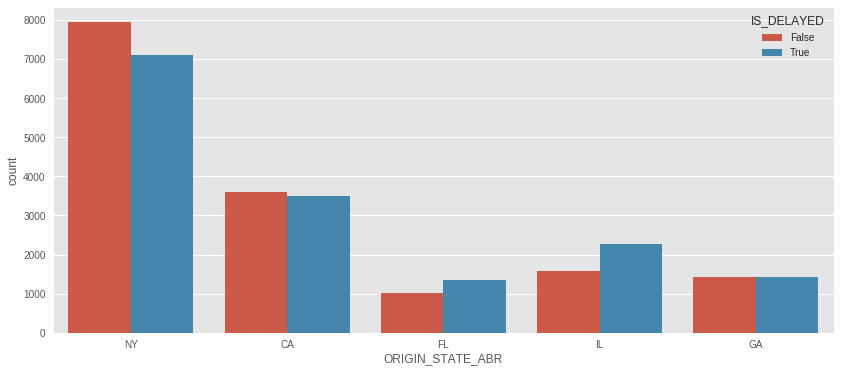

In [34]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='ORIGIN_STATE_ABR', data=df, hue='IS_DELAYED')
plt.show()

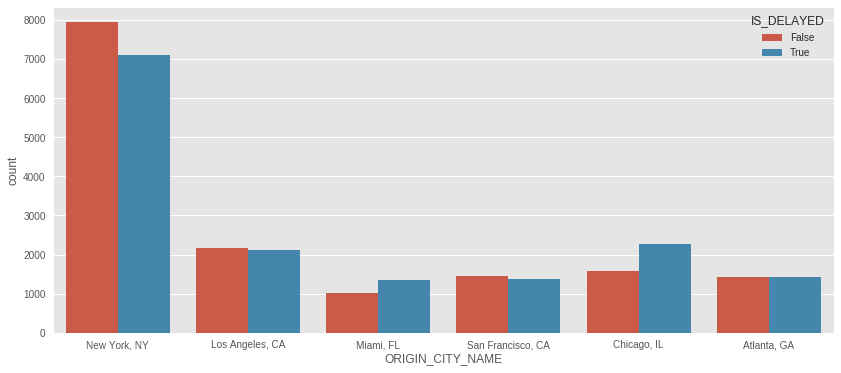

In [39]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='ORIGIN_CITY_NAME', data=df, hue='IS_DELAYED')
plt.show()

Comparing the two plots above we see that for all states represented by a single city of course the distribution is the same since no extra information is carried.

For the state of California we do not see a huge difference between Los Angeles and Atlanta. Meaning that departing from california state does not make a large difference either if you are from Los Angeles or from Atlanta

We have no reason to keep the origin state

In [40]:
df_5 = df_4.drop(labels=['ORIGIN_STATE_ABR'], axis=1)
df_5.shape

(31186, 19)

#### New York has two airports
due to the same analysis as above since all airports except are represented by one city the city brings no additional information

The issue is with New York city which has two airports. In particular it has JFK and LGA.

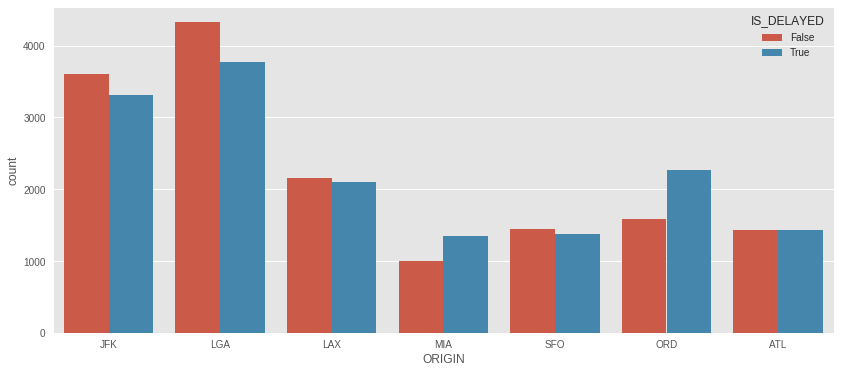

In [41]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='ORIGIN', data=df, hue='IS_DELAYED')
plt.show()

Again we don't see from bare eye that the difference among the two classes is any different of the difference of each individual airport (JFK and LGA) so no extra information is really provided by being in New York in general so we will remove the city attribute as well and keep only the airport

In [43]:
df_6 = df_5.drop(labels=['ORIGIN_CITY_NAME'], axis=1)
df_6.shape

(31186, 18)

#### Remove redundant destination flight information like State and City

In [48]:
list(df_6.groupby(['DEST_STATE_ABR', 'DEST_CITY_NAME', 'DEST']).size().keys())

[('CA', 'Los Angeles, CA', 'LAX'),
 ('CA', 'San Francisco, CA', 'SFO'),
 ('GA', 'Atlanta, GA', 'ATL'),
 ('IL', 'Chicago, IL', 'ORD'),
 ('MA', 'Boston, MA', 'BOS'),
 ('NY', 'New York, NY', 'JFK'),
 ('NY', 'New York, NY', 'LGA')]

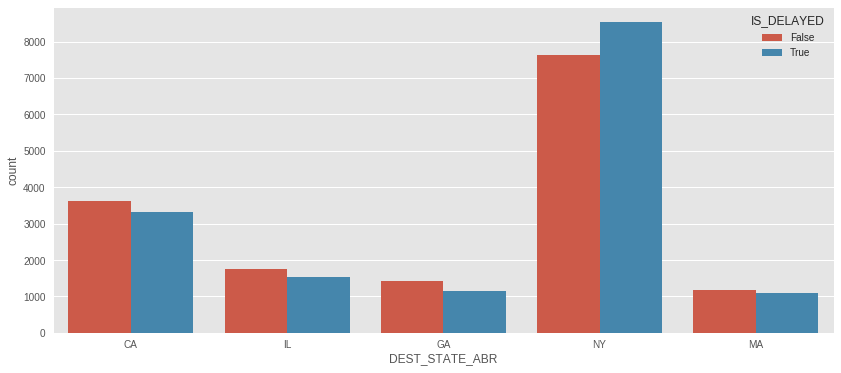

In [49]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='DEST_STATE_ABR', data=df, hue='IS_DELAYED')
plt.show()

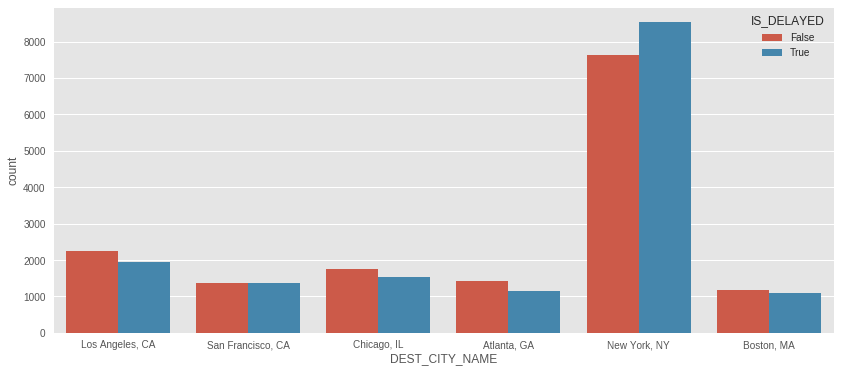

In [51]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='DEST_CITY_NAME', data=df, hue='IS_DELAYED')
plt.show()

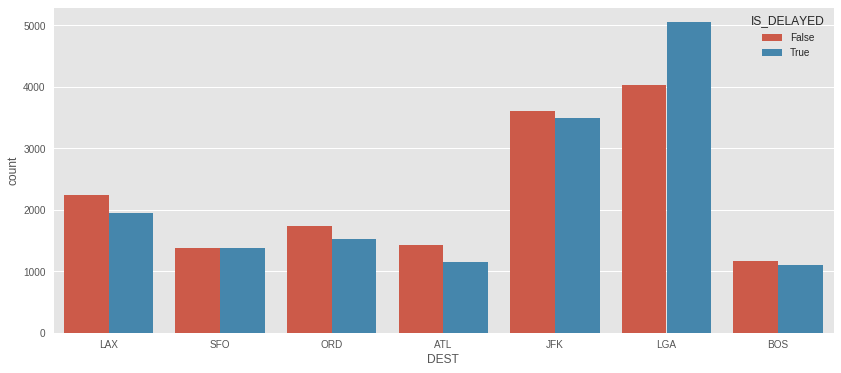

In [52]:
fig = plt.figure(figsize=(14,6))
sns.countplot(x='DEST', data=df, hue='IS_DELAYED')
plt.show()

We are dropping Destination State and Destination City as they offer no real extra value with what the destination airport is already offering

In [53]:
df_7 = df_6.drop(labels=['DEST_CITY_NAME', 'DEST_STATE_ABR'], axis=1)
df_7.shape

(31186, 16)

In [55]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31186 entries, 0 to 31185
Data columns (total 16 columns):
QUARTER             31186 non-null int64
MONTH               31186 non-null int64
DAY_OF_MONTH        31186 non-null int64
DAY_OF_WEEK         31186 non-null int64
UNIQUE_CARRIER      31186 non-null object
ORIGIN              31186 non-null object
DEST                31186 non-null object
DEP_TIME            31186 non-null float64
DEP_DELAY           31186 non-null float64
DEP_DELAY_NEW       31186 non-null float64
DEP_DEL15           31186 non-null float64
DEP_DELAY_GROUP     31186 non-null float64
DEP_TIME_BLK        31186 non-null object
CRS_ELAPSED_TIME    31186 non-null float64
DISTANCE            31186 non-null float64
DISTANCE_GROUP      31186 non-null int64
dtypes: float64(7), int64(5), object(4)
memory usage: 3.8+ MB


### Remove distance attributes
From the distribution plots seems that distance attributes offer minimum amount of value

In [58]:
df_8 = df_7.drop(labels=['DISTANCE', 'DISTANCE_GROUP'], axis=1)
df_8.shape

(31186, 14)

In [59]:
df_8.dtypes

QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
UNIQUE_CARRIER       object
ORIGIN               object
DEST                 object
DEP_TIME            float64
DEP_DELAY           float64
DEP_DELAY_NEW       float64
DEP_DEL15           float64
DEP_DELAY_GROUP     float64
DEP_TIME_BLK         object
CRS_ELAPSED_TIME    float64
dtype: object

### Departure time shift
From the departure time infomation which is actually the hour and minutes concatenated to form an integer (or a float) we would prefer it to have it shifted so that the day would start at the minimum value which is at 4 am approximately so that we would avoid large kurtosis on either positive or negative class distribution.

In [60]:
df_8.sample(5, random_state=random_state)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,CRS_ELAPSED_TIME
16192,1,1,0,0,B6,LAX,JFK,619.0,-1.0,0.0,0.0,-1.0,0600-0659,328.0
10496,0,0,0,0,VX,LAX,JFK,734.0,-1.0,0.0,0.0,-1.0,0700-0759,315.0
18939,1,1,1,1,B6,JFK,LAX,544.0,-1.0,0.0,0.0,-1.0,0001-0559,346.0
30189,0,0,0,0,NK,LGA,ORD,2154.0,-5.0,0.0,0.0,-1.0,2100-2159,147.0
25267,0,1,1,0,DL,JFK,SFO,1701.0,11.0,11.0,0.0,0.0,1600-1659,408.0


In [65]:
groupByTimeBlock = df_8.groupby(['DEP_TIME_BLK']).size()
groupByTimeBlock

DEP_TIME_BLK
0001-0559     341
0600-0659    1639
0700-0759    2286
0800-0859    1740
0900-0959    2090
1000-1059    1353
1100-1159    2284
1200-1259    1632
1300-1359    2060
1400-1459    1344
1500-1559    2137
1600-1659    2204
1700-1759    1997
1800-1859    1808
1900-1959    1493
2000-2059    1854
2100-2159    1789
2200-2259     495
2300-2359     640
dtype: int64

In [66]:
groupByTimeBlock.sort_values()

DEP_TIME_BLK
0001-0559     341
2200-2259     495
2300-2359     640
1400-1459    1344
1000-1059    1353
1900-1959    1493
1200-1259    1632
0600-0659    1639
0800-0859    1740
2100-2159    1789
1800-1859    1808
2000-2059    1854
1700-1759    1997
1300-1359    2060
0900-0959    2090
1500-1559    2137
1600-1659    2204
1100-1159    2284
0700-0759    2286
dtype: int64

So definitely between 0001 and 0559 we have the smaller number of flights

In [69]:
condition = df_8['DEP_TIME'] <= 559
groupByTime = df_8[condition].groupby(['DEP_TIME']).size()
groupByTime.sort_values()

DEP_TIME
208.0     1
49.0      1
113.0     1
112.0     1
241.0     1
235.0     1
109.0     1
108.0     1
234.0     1
118.0     1
220.0     1
103.0     1
229.0     1
226.0     1
102.0     1
58.0      1
57.0      1
46.0      1
207.0     1
105.0     1
119.0     1
53.0      1
124.0     1
206.0     1
157.0     1
155.0     1
153.0     1
149.0     1
148.0     1
139.0     1
         ..
3.0       6
39.0      7
28.0      7
19.0      7
13.0      7
11.0      7
540.0     8
539.0     9
542.0     9
33.0      9
9.0      10
541.0    10
4.0      10
544.0    13
549.0    13
543.0    13
547.0    14
548.0    15
545.0    16
546.0    17
550.0    17
551.0    19
553.0    35
552.0    38
559.0    53
557.0    54
554.0    56
555.0    71
556.0    71
558.0    72
dtype: int64

In [90]:
len(groupByTime)

132

In [70]:
first_time_block = df_8[condition]

In [91]:
histy, histx = np.histogram(first_time_block['DEP_TIME'], bins=len(groupByTime))
len(histx), len(histy)

(133, 132)

In [92]:
histy

array([ 32,  22,  22,  17,  20,  14,  21,  18,  20,  15,  13,  10,  10,
         7,   0,   0,   0,   0,   0,   0,   0,   0,   0,   8,   6,   6,
         7,   5,   6,   2,   2,   3,   2,   0,   1,   2,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   0,   0,   1,
         0,   2,   0,   2,   1,   2,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   1,  10,  40,  59,  59,
       148, 321])

In [93]:
histx[:-1]

array([   1.        ,    5.22727273,    9.45454545,   13.68181818,
         17.90909091,   22.13636364,   26.36363636,   30.59090909,
         34.81818182,   39.04545455,   43.27272727,   47.5       ,
         51.72727273,   55.95454545,   60.18181818,   64.40909091,
         68.63636364,   72.86363636,   77.09090909,   81.31818182,
         85.54545455,   89.77272727,   94.        ,   98.22727273,
        102.45454545,  106.68181818,  110.90909091,  115.13636364,
        119.36363636,  123.59090909,  127.81818182,  132.04545455,
        136.27272727,  140.5       ,  144.72727273,  148.95454545,
        153.18181818,  157.40909091,  161.63636364,  165.86363636,
        170.09090909,  174.31818182,  178.54545455,  182.77272727,
        187.        ,  191.22727273,  195.45454545,  199.68181818,
        203.90909091,  208.13636364,  212.36363636,  216.59090909,
        220.81818182,  225.04545455,  229.27272727,  233.5       ,
        237.72727273,  241.95454545,  246.18181818,  250.40909

In [95]:
diffs = np.zeros(len(histy))
for ii, elem in enumerate(histx):
    if ii > 0:
        diffs[ii-1] = elem - histx[ii-1]
diffs[:5]

array([ 4.22727273,  4.22727273,  4.22727273,  4.22727273,  4.22727273])

/home/student/anaconda2/envs/dme/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


<Container object of 132 artists>

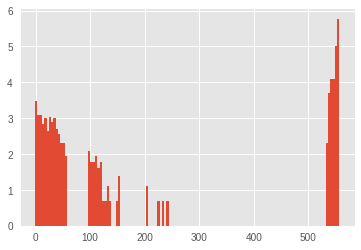

In [96]:
plt.bar(left=histx[:-1], height=np.log(histy), width=diffs)

Since we have zero trips let's pick the largest block of zeros in our trips

In [107]:
zeroBlockStart = []
zeroBlockEnd = []
for ii, (yelem, xelem, diffelem) in enumerate(zip(histy, histx[:-1], diffs)):
    if (yelem == 0 and ii == 0) or (yelem==0 and ii > 0 and histy[ii-1] != 0):
        zeroBlockStart.append(xelem)
    
    if ii > 0:
        if yelem != 0 and histy[ii-1]==0:
            zeroBlockEnd.append(xelem)
                                    
zeroBlockStart, zeroBlockEnd

([60.181818181818187,
  140.5,
  157.40909090909091,
  208.13636363636365,
  220.81818181818184,
  229.27272727272728,
  250.40909090909093],
 [98.227272727272734,
  144.72727272727275,
  203.90909090909093,
  216.59090909090909,
  225.04545454545456,
  233.5,
  525.18181818181824])

In [108]:
zeroBlockStart_arr = np.array(zeroBlockStart)[np.newaxis].T
zeroBlockEnd_arr = np.array(zeroBlockEnd)[np.newaxis].T
zeroBlocks = np.hstack( (zeroBlockStart_arr, zeroBlockEnd_arr, zeroBlockEnd_arr - zeroBlockStart_arr) )

zeroBlocks

array([[  60.18181818,   98.22727273,   38.04545455],
       [ 140.5       ,  144.72727273,    4.22727273],
       [ 157.40909091,  203.90909091,   46.5       ],
       [ 208.13636364,  216.59090909,    8.45454545],
       [ 220.81818182,  225.04545455,    4.22727273],
       [ 229.27272727,  233.5       ,    4.22727273],
       [ 250.40909091,  525.18181818,  274.77272727]])

In [113]:
largestZeroBlock_ind = np.argmax(zeroBlocks[:, 2])
largestZeroBlock_ind

6

In [115]:
largestZeroBlock = zeroBlocks[largestZeroBlock_ind]
largestZeroBlock[:2]

array([ 250.40909091,  525.18181818])

#### We are defining the start of the day as the average value between the start and end point of the largest zero block

In [117]:
startOfDay = np.mean(largestZeroBlock)
startOfDay

350.12121212121218

In [118]:
largestTime = np.max(df_8['DEP_TIME'])
largestTime

2400.0

In [119]:
timeCol = df_8['DEP_TIME'].copy()

In [121]:
timeShifted = timeCol - startOfDay
timeShifted.shape

(31186,)

In [123]:
timeShifted[timeShifted < 0] += largestTime

In [125]:
df_9 = df_8.copy()

In [126]:
df_9['DEP_TIME'] = timeShifted

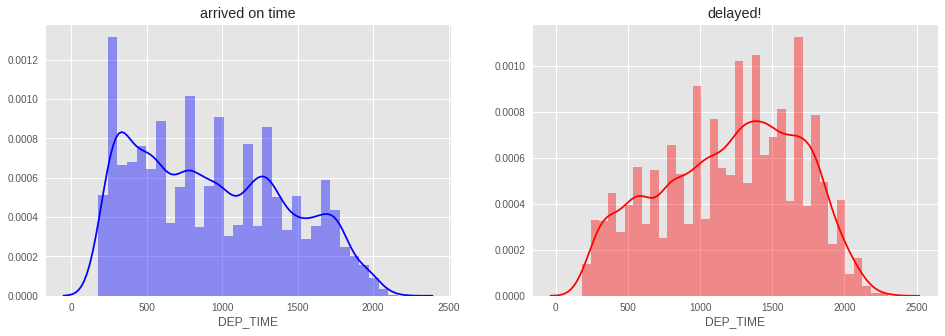

In [127]:
plotDistsPerClass(XX=df_9, yy=yy, colname='DEP_TIME')

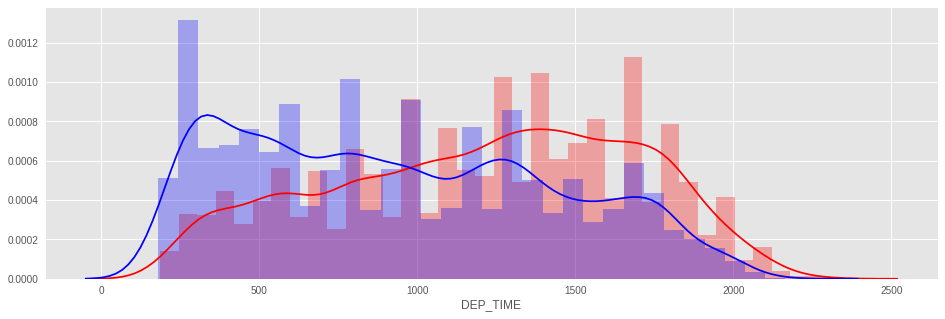

In [128]:
plotBothDists(XX=df_9, yy=yy, colname='DEP_TIME')

### Drop departure time block which is no longer relevant after the above transformation

In [130]:
df_10 = df_9.drop(labels=['DEP_TIME_BLK'], axis=1)
df_10.dtypes

QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
UNIQUE_CARRIER       object
ORIGIN               object
DEST                 object
DEP_TIME            float64
DEP_DELAY           float64
DEP_DELAY_NEW       float64
DEP_DEL15           float64
DEP_DELAY_GROUP     float64
CRS_ELAPSED_TIME    float64
dtype: object

## Account for previous delays from the same airport
The algorithm goes like this:
- get all flights from origin airport
- go back to departure time, for some hours, but only within same day
- sum all departure delays and divide by number of flights corresponding to that to get delay per flight
- Make this a feature

In [204]:
feature_prev_delays = FeaturePrevDelays(data_frame=df, mins_set=[30, 60, 120, 180, 360, 720])

In [206]:
%%time
df_11 = feature_prev_delays.transform(data_frame=df_10)
df_11.dtypes

CPU times: user 27min 38s, sys: 252 ms, total: 27min 38s
Wall time: 27min 38s


In [209]:
df_11.dtypes

QUARTER               int64
MONTH                 int64
DAY_OF_MONTH          int64
DAY_OF_WEEK           int64
UNIQUE_CARRIER       object
ORIGIN               object
DEST                 object
DEP_TIME            float64
DEP_DELAY           float64
DEP_DELAY_NEW       float64
DEP_DEL15           float64
DEP_DELAY_GROUP     float64
CRS_ELAPSED_TIME    float64
PREV_DELAYS_30      float64
PREV_DELAYS_60      float64
PREV_DELAYS_120     float64
PREV_DELAYS_180     float64
PREV_DELAYS_360     float64
PREV_DELAYS_720     float64
dtype: object

In [208]:
df_11.sample(5)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,CRS_ELAPSED_TIME,PREV_DELAYS_30,PREV_DELAYS_60,PREV_DELAYS_120,PREV_DELAYS_180,PREV_DELAYS_360,PREV_DELAYS_720
21918,1,1,0,1,VX,SFO,JFK,1182.878788,103.0,103.0,1.0,6.0,339.0,0.0,2.0,36.0,55.2,75.285714,65.125
12532,1,1,0,0,VX,SFO,JFK,1107.878788,68.0,68.0,1.0,4.0,339.0,0.0,0.0,0.0,39.0,16.666667,9.000
21166,0,0,0,0,AA,JFK,LAX,1480.878788,1.0,1.0,0.0,0.0,389.0,0.0,0.0,0.0,-5.0,-3.333333,-1.375
21065,0,0,0,0,UA,ORD,LGA,408.878788,-1.0,0.0,0.0,-1.0,130.0,0.0,0.0,0.0,0.0,-4.000000,-4.000
18296,0,0,0,0,AA,LAX,JFK,888.878788,69.0,69.0,1.0,4.0,328.0,0.0,0.0,-3.0,-3.0,4.500000,0.400


## Account delays of same airline
Algorithm:
- keep trips where destination is origin's target
- keep trips only of the same day
- keep trips of same airline
- keep trips where the departure time is target's departure time - CRS elapsed time (even if they just arrived)
- go further back in time within the same day and consume all departure delays as above
    - sum dep delays and divide  by number of flights

In [212]:
feature_airline_delays = FeatureAirlineDelays(data_frame = df, mins_set=[30, 60, 120, 180, 360, 720])

In [214]:
%%time

df_12 = feature_airline_delays.transform(data_frame=df_11)
print df_12.shape

(31186, 25)
CPU times: user 32min 35s, sys: 548 ms, total: 32min 35s
Wall time: 32min 36s


In [217]:
df_12.sample(10)

,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,...,PREV_DELAYS_120,PREV_DELAYS_180,PREV_DELAYS_360,PREV_DELAYS_720,AIRLINE_DELAYS_30,AIRLINE_DELAYS_60,AIRLINE_DELAYS_120,AIRLINE_DELAYS_180,AIRLINE_DELAYS_360,AIRLINE_DELAYS_720
26751,1,1,0,0,AA,ORD,LGA,1378.878788,-6.0,0.0,...,0.000000,0.000000,41.000000,10.800000,0.0,0.0,0.0,32.0,58.000000,77.0
224,0,0,1,0,AA,LAX,JFK,1902.878788,83.0,83.0,...,0.000000,0.000000,0.000000,64.000000,0.0,0.0,0.0,7.0,7.000000,3.0
2183,0,0,0,1,DL,LGA,ATL,508.878788,-1.0,0.0,...,-2.000000,29.000000,5.571429,5.571429,0.0,0.0,0.0,0.0,0.000000,0.0
16359,0,0,0,0,AA,ORD,LGA,478.878788,4.0,4.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
7511,0,1,0,1,B6,JFK,SFO,1462.878788,3.0,3.0,...,2.500000,6.500000,6.200000,8.000000,0.0,0.0,0.0,0.0,9.500000,9.5
16416,0,0,0,0,UA,LGA,ORD,1664.878788,15.0,15.0,...,11.666667,11.666667,16.555556,21.454545,0.0,0.0,0.0,0.0,0.000000,0.0
15075,0,0,1,0,DL,LGA,ATL,1204.878788,-5.0,0.0,...,-6.000000,-6.000000,5.000000,6.200000,0.0,0.0,-1.0,-1.0,-1.000000,-2.5
10717,0,1,0,1,B6,LAX,JFK,1050.878788,1.0,1.0,...,2.000000,5.500000,9.000000,18.800000,0.0,0.0,0.0,0.0,-5.000000,-5.0
6498,1,1,0,1,AA,JFK,LAX,1463.878788,14.0,14.0,...,25.500000,29.600000,24.500000,24.500000,0.0,0.0,0.0,56.0,15.666667,19.0
16207,0,0,0,0,AA,LAX,JFK,204.878788,-5.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


In [215]:
df_12.dtypes

QUARTER                 int64
MONTH                   int64
DAY_OF_MONTH            int64
DAY_OF_WEEK             int64
UNIQUE_CARRIER         object
ORIGIN                 object
DEST                   object
DEP_TIME              float64
DEP_DELAY             float64
DEP_DELAY_NEW         float64
DEP_DEL15             float64
DEP_DELAY_GROUP       float64
CRS_ELAPSED_TIME      float64
PREV_DELAYS_30        float64
PREV_DELAYS_60        float64
PREV_DELAYS_120       float64
PREV_DELAYS_180       float64
PREV_DELAYS_360       float64
PREV_DELAYS_720       float64
AIRLINE_DELAYS_30     float64
AIRLINE_DELAYS_60     float64
AIRLINE_DELAYS_120    float64
AIRLINE_DELAYS_180    float64
AIRLINE_DELAYS_360    float64
AIRLINE_DELAYS_720    float64
dtype: object

## One hot encodings

In [220]:
df_13 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = df_12, col_name = 'UNIQUE_CARRIER')
df_13.shape

(31186, 32)

In [221]:
df_14 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = df_13, col_name = 'ORIGIN')
df_14.shape

(31186, 37)

In [222]:
df_15 = MyOneHotEncoder().encodePandasColAndMerge(data_frame = df_14, col_name = 'DEST')
df_15.shape

(31186, 42)

In [227]:
final_df = pd.concat( (df_15, yy), axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31186 entries, 0 to 31185
Data columns (total 43 columns):
QUARTER               31186 non-null int64
MONTH                 31186 non-null int64
DAY_OF_MONTH          31186 non-null int64
DAY_OF_WEEK           31186 non-null int64
DEP_TIME              31186 non-null float64
DEP_DELAY             31186 non-null float64
DEP_DELAY_NEW         31186 non-null float64
DEP_DEL15             31186 non-null float64
DEP_DELAY_GROUP       31186 non-null float64
CRS_ELAPSED_TIME      31186 non-null float64
PREV_DELAYS_30        31186 non-null float64
PREV_DELAYS_60        31186 non-null float64
PREV_DELAYS_120       31186 non-null float64
PREV_DELAYS_180       31186 non-null float64
PREV_DELAYS_360       31186 non-null float64
PREV_DELAYS_720       31186 non-null float64
AIRLINE_DELAYS_30     31186 non-null float64
AIRLINE_DELAYS_60     31186 non-null float64
AIRLINE_DELAYS_120    31186 non-null float64
AIRLINE_DELAYS_180    31186 non-null float64

In [228]:
final_df.to_csv(
    os.path.realpath(os.path.join(os.getcwd(), '../Data', 'train_data_v2_engineered.csv')),
    index=False)